In [1]:
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.constants import G

import matplotlib.pyplot as plt

# set font size to 13
plt.rcParams.update({'font.size': 13})

def get_mass_loss_rate(factor, angle, flare_rate, alpha, Emin, Emax, a, Rstar, planet_radius, planet_mass):

    # derive offset of the power law 
    beta = flare_rate.value * (alpha -1) / (Emin.value**(1-alpha)) 

    # set a maximum energy for the flares we want to consider
    E = 1e33 # lower energy limit  -- roughly the flare energy that can be detected in X-ray with current instruments

    # FFD integral
    tot_flux =  beta * (Emax**(-alpha + 2) - E**(-alpha + 2))  / (-alpha + 2)  * u.erg / u.d

    # !ATTENTION EFFICIENCY FACTOR!
    # the factor is =1 if flare energy = CME energy (see Moschou+2019, Emslie+2012)
    # and if all flares are associated with CMEs
    tot_flux *= factor

    # assume that the CME has an opening angle of 60 degrees, where opening angle
    #  is the angle between the two opposite edge of the CME cone
    opening_angle = (angle * u.deg).to("rad").value

    # convert opening angle to fraction of 1-sphere covered
    fraction_of_sphere_covered = (1 - np.cos(opening_angle / 2)) / 2

    # convert to area
    area_covered_at_planet_orbital_distance = 4 * np.pi * ((a - 1) * Rstar)**2 * fraction_of_sphere_covered

    # calculate the energy dumped in to the planet atmosphere per second 
    # (i.e. use optical planet radius as cross section)
    cme_impact_flux = (tot_flux / area_covered_at_planet_orbital_distance * np.pi* planet_radius**2).to("erg/s")

    # calculate mass loss rate from 
    # energy to lift a mass out of the planet's gravity well
    # i.e. energy-limited escape
    # E = GMm/R where m is the mass we're looking for
    # m = E * R / GM
    # E -> Flux and m -> mass loss rate by dividing by time
    mass_loss_rate = (cme_impact_flux * planet_radius / G / planet_mass).to("Mearth/Myr") 

    return mass_loss_rate

In [2]:
# planet parameters

a = 11.7
Rstar = 1.39 * u.Rsun
planet_radius = 0.0668 * u.Rsun

# Thao+2024 results
planet_mass =  15 * u.Mearth # best fit from Thao+2024
thao_dot_m = 0.015 # mass loss rate from Thao+2024 in Earth Masses per Myr

# flares table 
flares = pd.read_csv("../results/hip67522_flares.csv").sort_values("mean_bol_energy", ascending=True)

# maximum flare energy in sample
Emax = flares.mean_bol_energy.max() 
# threshold energy
Emin = flares.mean_bol_energy.iloc[1] * u.erg

# planet-induced flare rate
flare_rate = 0.5 / u.day

# power law slope
alpha = 1.5

print("Maximum flare energy in sample: ", Emax)
print("Minimum flare energy in sample: ", Emin)


Maximum flare energy in sample:  8.47962320891151e+35
Minimum flare energy in sample:  6.87362349239785e+33 erg


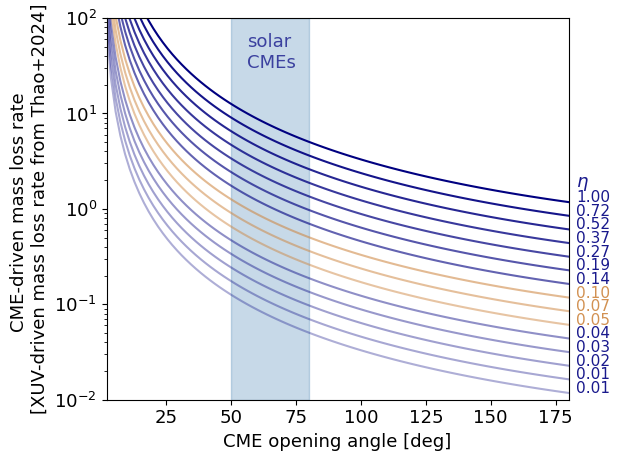

In [17]:
factors = np.logspace(-2, 0, 15)
angles = np.linspace(0, 180, 100)

params = (flare_rate, alpha, Emin, Emax, a, Rstar, planet_radius, planet_mass)

for f in factors:
    if 0.04 < f < 0.13:
        c="peru"
    else:
        c="navy"
    plt.plot(angles, 
             get_mass_loss_rate(f, angles, *params) / thao_dot_m, 
             label=f, alpha=f**(1/4), c=c)

    # annotate with f
    x, y = 183 , get_mass_loss_rate(f, angles[-1], *params).value / thao_dot_m
    plt.text(x, y, f"{f:.2f}", color=c, alpha=0.9, fontsize=11)

plt.text(183, 1.7, r"$\eta$", color="navy", fontsize=13, alpha=0.9)

# plt.axhline(1.3)
# plt.axhline(0.5)

# fill between 40 and 80 deg
# plt.fill_between([40, 100], 0.01, 100, color="steelblue", alpha=0.3)
plt.fill_between([50, 80], 0.01, 100, color="steelblue", alpha=0.3)
plt.text(56, 30, "solar\nCMEs", color="navy", fontsize=13, alpha=0.7)

plt.yscale("log")
plt.xlim(2, 180)
plt.ylim(0.01, 100)
plt.ylabel("CME-driven mass loss rate \n[XUV-driven mass loss rate from Thao+2024]", fontsize=13)
plt.xlabel("CME opening angle [deg]", fontsize=13)
plt.tight_layout()



plt.savefig("../plots/mass_loss_rate_vs_cme_angle.png", dpi=300)



In [8]:
1000 / 2.3, 1000/1.5

(434.7826086956522, 666.6666666666666)

In [37]:
1000/ 1.3, 1000/1.5

(769.2307692307692, 666.6666666666666)